In [161]:
#!pip install -U scikit-learn
#!pip install autograd

In [163]:
!python3 --version

Python 3.9.1


# 1st Assignment: NN's from Scratch 

By: Jan Leyva Massagué

The objective is to build from scratch a neural network to perform  classification. Let's firt consider the follwing 2-class dataset:

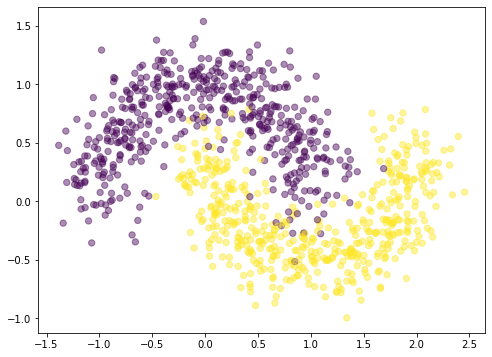

In [52]:
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import autograd.numpy as np
from autograd import grad
from autograd.misc import flatten
from sklearn.metrics import confusion_matrix
import seaborn as sns

# import help functions for plot the Confusion Matrix
from help_functions import ConfMatrix


n = 1000

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(n, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, alpha=0.45)

In [2]:
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, \
                     fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', \
                ylabel='True values');
    print("Accuracy:", (sum(np.diag(confusion_matrix(yTrue, yEst)))/len(yTrue))*100, "%")

We will use a **3-layer classification neural network** with one input layer, one hidden layer, and one output layer. 

The number of nodes in the input layer will be determined by the dimensionality of our data (2). Similarly, the number of nodes in the output layer is determined by the number of classes $C$ we have (also 2). 

Our network makes predictions using forward propagation, which is just a bunch of matrix multiplications and the application of the activation function $\sigma$. 

If $x$ is the input to our network then we calculate our prediction $\hat{y}$ as follows:

$$ z_1 = x W_1 + b_1 $$
$$ a_1 = \sigma(z_1) $$
$$ z_2 = a_1 W_2 + b_2$$
$$ y = \mbox{softmax}({z_2})$$

where $y$ is a multidimensional vector representing a probability distribution over classes, $\sigma$ is a non linear function and $W_1, b_1, W_2, b_2$ are parameters of our network, which we need to learn from our training data. You can think of the parameters $W$ as matrices transforming data between layers of the network. 

Looking at the matrix multiplications above we can figure out the dimensionality of these matrices in our problem. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. 

The last layer is a `softmax` function. The softmax function is a generalization of the logistic function to multiple dimensions. It is used to normalize the output of a network to a probability distribution over predicted output classes.

The softmax function takes as input a vector $C$ of real numbers, and normalizes it into a probability distribution consisting of $C$ probabilities proportional to the exponentials of the input numbers:

$$softmax(z_i) = \frac{exp(z_i)}{\sum_{j=1}^{C}exp(z_j))}$$

A common choice with the softmax output is the **cross-entropy loss**. If we have $N$ training examples in our minibatch dataset and $C$ classes, then the loss for our prediction $\hat{y}$ for that minibatch with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Let's now define some general parameters:

In [334]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality
sigma = np.tanh # activation function

# Gradient descent parameters 
epsilon = 0.03 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [4]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [5]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
        if i % 50000 == 0:
            print("End of the trainning process")
    return model

# Build a model with a 3-dimensional hidden layer
modelV1 = build_model(3, print_loss=True)

Loss after iteration 0: 0.579072
Loss after iteration 1000: 0.318194
Loss after iteration 2000: 0.297823
Loss after iteration 3000: 0.292968
Loss after iteration 4000: 0.289702
Loss after iteration 5000: 0.286239
Loss after iteration 6000: 0.282110
Loss after iteration 7000: 0.277041
Loss after iteration 8000: 0.270838
Loss after iteration 9000: 0.263436
Loss after iteration 10000: 0.254934
Loss after iteration 11000: 0.245598
Loss after iteration 12000: 0.235800
Loss after iteration 13000: 0.225928
Loss after iteration 14000: 0.216313
Loss after iteration 15000: 0.207199
Loss after iteration 16000: 0.198736
Loss after iteration 17000: 0.190997
Loss after iteration 18000: 0.183991
Loss after iteration 19000: 0.177694
Loss after iteration 20000: 0.172053
Loss after iteration 21000: 0.167009
Loss after iteration 22000: 0.162497
Loss after iteration 23000: 0.158456
Loss after iteration 24000: 0.154825
Loss after iteration 25000: 0.151550
Loss after iteration 26000: 0.148580
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

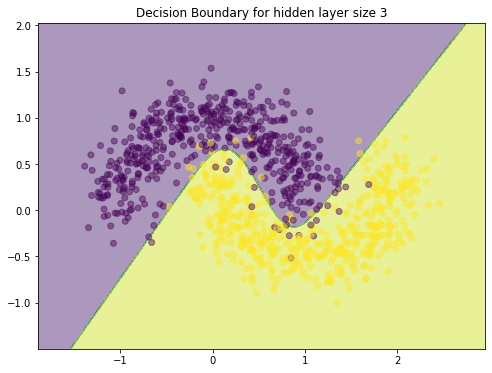

In [6]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.45)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.45)

    
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(modelV1, x))
plt.title("Decision Boundary for hidden layer size 3")

Accuracy: 96.2 %


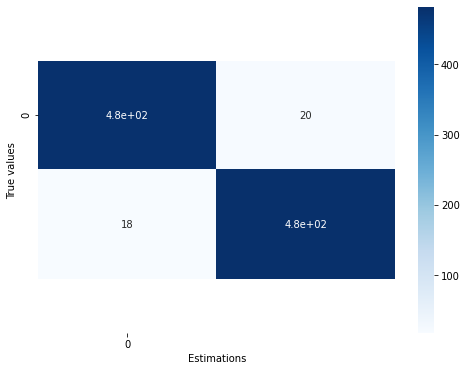

In [7]:
pred = predict(modelV1, X)
plotConfusionMatrix(y, pred, classes = 2)

# Exercise 1

Add an additional layer to your neural network model. Change the activation function and use a ReLU. Does it work?


## First we will try with an additional layer

In [8]:
# loss function for a 4-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = sigma(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    return model

# Build a model with a 3-dimensional hidden layer
model_4layers = build_model(3, print_loss=True)

Loss after iteration 0: 0.617549
Loss after iteration 1000: 0.317421
Loss after iteration 2000: 0.308015
Loss after iteration 3000: 0.303026
Loss after iteration 4000: 0.297792
Loss after iteration 5000: 0.292547
Loss after iteration 6000: 0.287833
Loss after iteration 7000: 0.283902
Loss after iteration 8000: 0.280724
Loss after iteration 9000: 0.278161
Loss after iteration 10000: 0.276066
Loss after iteration 11000: 0.274319
Loss after iteration 12000: 0.272824
Loss after iteration 13000: 0.271502
Loss after iteration 14000: 0.270267
Loss after iteration 15000: 0.268982
Loss after iteration 16000: 0.267272
Loss after iteration 17000: 0.263532
Loss after iteration 18000: 0.251761
Loss after iteration 19000: 0.231750
Loss after iteration 20000: 0.210617
Loss after iteration 21000: 0.188502
Loss after iteration 22000: 0.167907
Loss after iteration 23000: 0.151347
Loss after iteration 24000: 0.139099
Loss after iteration 25000: 0.130491
Loss after iteration 26000: 0.124501
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 3')

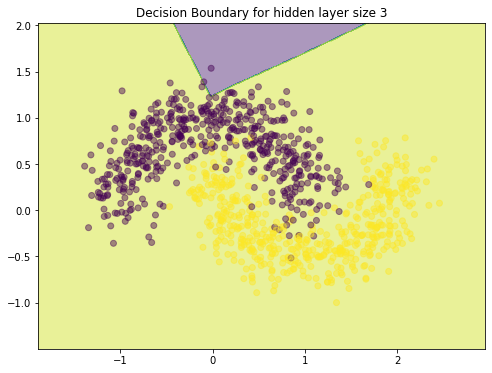

In [29]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_4layers, x))
plt.title("Decision Boundary for hidden layer size 3")

Accuracy: 96.89999999999999 %


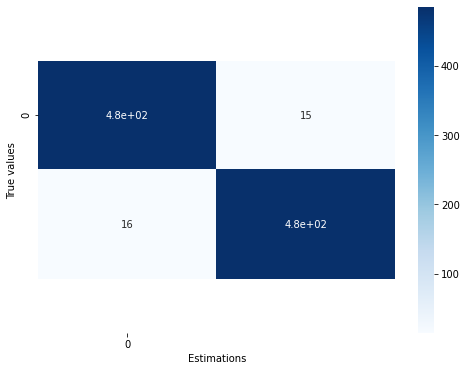

In [11]:
pred_4layers = predict(model_4layers, X)
plotConfusionMatrix(y, pred_4layers, classes = 2)

In [6]:
# your code here





##  Now we going to check what happen if we change it for a ReLU as activation function

Parametric ReLUs (PReLUs) take this idea further by making the coefficient of leakage into a parameter that is learned along with the other neural-network parameters.

\begin{cases}x&{\text{if }}x>0,\\ax&{\text{otherwise}}.\end{cases}


otherwise:


Note that for a ≤ 1, this is equivalent to

$$f(x)=\max(x,ax)$$

In [270]:
def reLU(x):
    x*(x>0)
    return x

In [287]:
def reLU(x):
    if x > 0.:
        x = x
    else:
        x = 0.
    return x

In [12]:
def reLU(x):
    x = np.maximum(0, x)
    return x

In [309]:
# x = np.array([0, 1, 100, -100])

reLU(x)

array([  0,   1, 100,   0])

In [24]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [37]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
        if i == (num_passes-1):
            print("End of the trainning process") 
            
    return model

# Build a model with a 3-dimensional hidden layer
model_ReLU = build_model(4, print_loss=False)

End of the trainning process


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

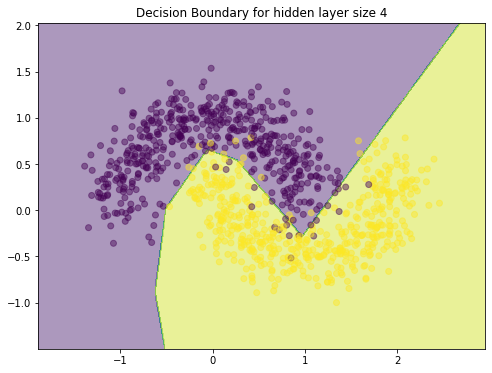

In [38]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_ReLU, x))
plt.title("Decision Boundary for hidden layer size 4")

Accuracy: 96.3 %


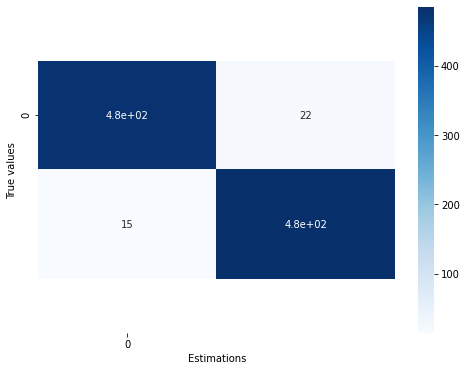

In [39]:
pred_ReLU = predict(model_ReLU, X)
plotConfusionMatrix(y, pred_ReLU, classes = 2)

# Exercise 2

Design (change parameters) and train a NN to classify the following dataset. 

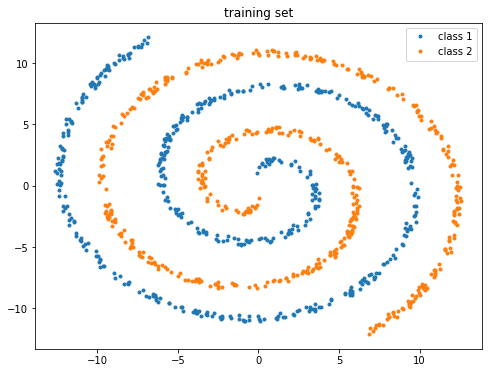

In [65]:
import numpy
import matplotlib.pyplot as plt

def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = numpy.sqrt(numpy.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -numpy.cos(n)*n + numpy.random.rand(n_points,1) * noise
    d1y = numpy.sin(n)*n + numpy.random.rand(n_points,1) * noise
    return (numpy.vstack((numpy.hstack((d1x,d1y)),numpy.hstack((-d1x,-d1y)))), 
            numpy.hstack((numpy.zeros(n_points),numpy.ones(n_points))))

X, y = twospirals(500)

y = y.astype(int)


plt.title('training set')
plt.plot(X[y==0,0], X[y==0,1], '.', label='class 1')
plt.plot(X[y==1,0], X[y==1,1], '.', label='class 2')
plt.legend()
plt.show()

In [64]:
X.shape

(2000, 2)

In [57]:
type(y)

numpy.ndarray

In [8]:
# your code here

In [78]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = np.dot(x,W1) + b1
    a1 = sigma(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [79]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
    
        if i == (num_passes-1):
            print("End of the trainning process") 
    return model

# Build a model with a 3-dimensional hidden layer
model_v2 = build_model(50, print_loss=True)

Loss after iteration 0: 0.725636
Loss after iteration 1000: 0.643546
Loss after iteration 2000: 0.631117
Loss after iteration 3000: 0.622082
Loss after iteration 4000: 0.615658
Loss after iteration 5000: 0.611238
Loss after iteration 6000: 0.607873
Loss after iteration 7000: 0.605089
Loss after iteration 8000: 0.602643
Loss after iteration 9000: 0.600403
Loss after iteration 10000: 0.598273
Loss after iteration 11000: 0.596294
Loss after iteration 12000: 0.594529
Loss after iteration 13000: 0.592973
Loss after iteration 14000: 0.591605
Loss after iteration 15000: 0.590385
Loss after iteration 16000: 0.589272
Loss after iteration 17000: 0.588234
Loss after iteration 18000: 0.587255
Loss after iteration 19000: 0.586327
Loss after iteration 20000: 0.585436
Loss after iteration 21000: 0.584565
Loss after iteration 22000: 0.583715
Loss after iteration 23000: 0.582903
Loss after iteration 24000: 0.582141
Loss after iteration 25000: 0.581422
Loss after iteration 26000: 0.580737
Loss after ite

In [104]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_v2, x))
plt.title("Decision Boundary for hidden layer size 4")

KeyError: 'W3'

Accuracy: 68.4 %


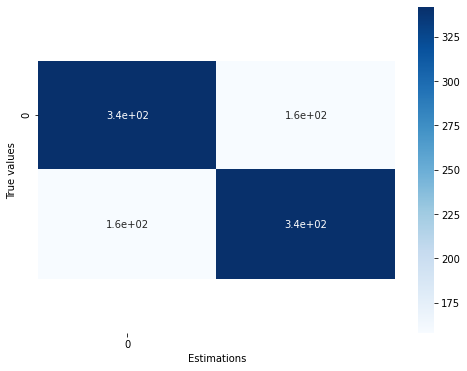

In [81]:
pred_Spiral = predict(model_v2, X)
plotConfusionMatrix(y, pred_Spiral, classes = 2)

## Two hidden layers + ReLU Activation function

In [335]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    z1 = np.dot(x,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # we try to change the second act f(x) as linear
    z3 = np.dot(a2,W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [347]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=100000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(1)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
        if i == (num_passes-1):
            print("End of the trainning process") 
            
    return model

# Build a model with a 3-dimensional hidden layer
model_Spiralv2 = build_model(8, print_loss=True)

Loss after iteration 0: 0.829632
Loss after iteration 1000: 0.637343
Loss after iteration 2000: 0.629044
Loss after iteration 3000: 0.620707
Loss after iteration 4000: 0.619639
Loss after iteration 5000: 0.616296
Loss after iteration 6000: 0.614175
Loss after iteration 7000: 0.612913
Loss after iteration 8000: 0.612366
Loss after iteration 9000: 0.611134
Loss after iteration 10000: 0.610110
Loss after iteration 11000: 0.609614
Loss after iteration 12000: 0.609024
Loss after iteration 13000: 0.608588
Loss after iteration 14000: 0.608225
Loss after iteration 15000: 0.607599
Loss after iteration 16000: 0.607378
Loss after iteration 17000: 0.607048
Loss after iteration 18000: 0.606832
Loss after iteration 19000: 0.606483
Loss after iteration 20000: 0.606175
Loss after iteration 21000: 0.606071
Loss after iteration 22000: 0.605415
Loss after iteration 23000: 0.605109
Loss after iteration 24000: 0.604605
Loss after iteration 25000: 0.603848
Loss after iteration 26000: 0.603428
Loss after ite

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 8')

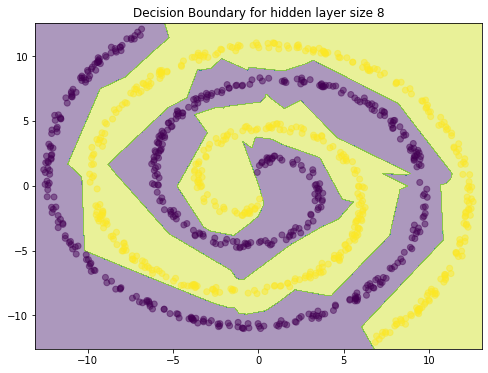

In [349]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_Spiralv2, x))
plt.title("Decision Boundary for hidden layer size 8")

Accuracy: 100.0 %


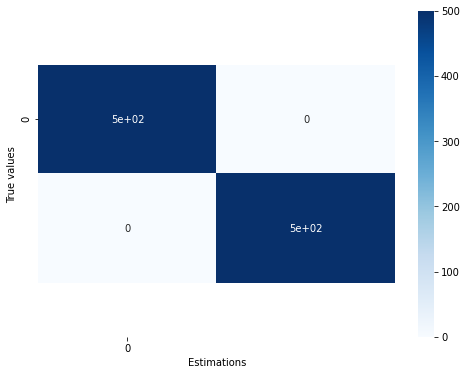

In [348]:
pred_Spiralv2 = predict(model_Spiralv2, X)
plotConfusionMatrix(y, pred_Spiralv2, classes = 2)

## 3 hidden layers + ReLU Activation function

In [246]:
# loss function for a 3-layer MLP
def loss(model):
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4']
    # Forward propagation to calculate our predictions
    z1 = np.dot(X,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # changed the activation function to `ReLU`
    z3 = np.dot(a2,W3) + b3
    a3 = reLU(z3)
    z4 = np.dot(a3,W4) + b4
    
    exp_scores = np.exp(z4)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda * (np.sum(np.square(W1)) + np.sum(np.square(W2))) + np.sum(np.square(W3))
    return 1./num_examples * data_loss

# forward propagation
def predict(model, x):
    W1, b1, W2, b2, W3, b3, W4, b4 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3'], model['W4'], model['b4']
    z1 = np.dot(x,W1) + b1
    a1 = reLU(z1)              # changed the activation function to `ReLU`
    z2 = np.dot(a1,W2) + b2
    a2 = reLU(z2)              # we try to change the second act f(x) as linear
    z3 = np.dot(a2,W3) + b3
    a3 = reLU(z3)
    z4 = np.dot(a3,W4) + b4    
    
    exp_scores = np.exp(z4)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [249]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_model(nn_hdim, num_passes=50000, print_loss=False):
    
    # Initialize the parameters to random values. 
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_hdim))
    W3 = np.random.randn(nn_hdim, nn_hdim) / np.sqrt(nn_hdim)
    b3 = np.zeros((1, nn_output_dim))
    W4 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b4 = np.zeros((1, nn_output_dim))
    
    # This is what we return at the end
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        predict(model, X)

        # computing the derivative by AD        
        gradient_loss = grad(loss)

        # flattening nested containers containing numpy arrays
        # Returns 1D numpy array and an unflatten function.
        model_flat, unflatten_m = flatten(model)
        grad_flat, unflatten_g = flatten(gradient_loss(model))
        
        # gradient descend
        model_flat -= grad_flat * epsilon
        model = unflatten_m(model_flat)

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, loss(model)))
    
        if i == (num_passes-1):
            print("End of the trainning process") 
            
    return model

# Build a model with a 3-dimensional hidden layer
model_Spiralv2 = build_model(8, print_loss=False)

End of the trainning process


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 8')

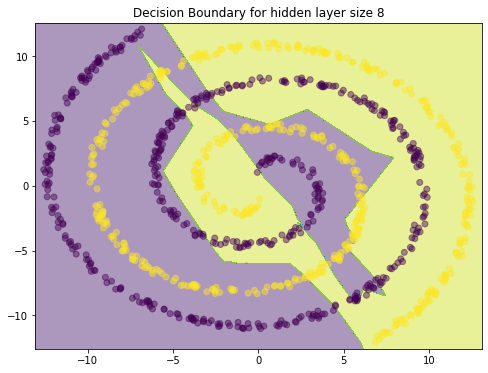

In [252]:
# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model_Spiralv2, x))
plt.title("Decision Boundary for hidden layer size 8")

Accuracy: 60.5 %


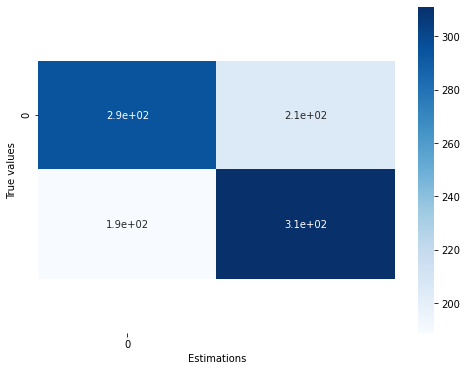

In [288]:
pred_Spiralv2 = predict(model_Spiralv2, X)
plotConfusionMatrix(y, pred_Spiralv2, classes = 2)

In [257]:
a1.shape

(1000, 8)

In [264]:
W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
(np.dot(a1,W2) + b2).shape

(1000, 2)

In [265]:
b2.shape

(1000, 2)